# Homework 1| Danny Stein



In [73]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
import scipy.optimize as optimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13
import sys
sys.path.insert(0,'C:/Users/dcste/OneDrive/fixed_income/Fixed_Income/treasury_cmds.py')
from treasury_cmds import *

In [74]:
df = pd.read_excel('C:/Users/dcste/OneDrive/fixed_income/Fixed_Income/treasury_quotes_2022-09-30.xlsx')
df.columns = df.columns.str.upper()
df.sort_values('TMATDT', inplace = True)
df.set_index('KYTREASNO', inplace = True)
df.head()

,KYCRSPID_X,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,...,TFCALDT,TNOTICE,IYMCN,ITYPE,IUNIQ,ITAX,IFLWR,TBANKDT,TSTRIPELIG,TFRGNTGT
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,20221004.400000,2022-09-30,99.973333,99.973444,99.973389,M,I,0.000000,-1.389258e-07,0.000067,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207774,20221006.400000,2022-09-30,99.960917,99.961083,99.961000,M,I,0.000000,-2.542594e-05,0.000065,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207893,20221011.400000,2022-09-30,99.924986,99.925292,99.925139,M,I,0.000000,1.473347e-05,0.000068,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207868,20221013.400000,2022-09-30,99.907556,99.907917,99.907736,M,I,0.000000,-8.270836e-05,0.000071,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207430,20221015.201370,2022-09-30,99.921875,99.953125,99.937500,M,I,0.631148,3.735728e-05,0.000079,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN


In [75]:
t_check = df['CALDT'].values[0]
if df['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None
f'These quotes are based on {pd.to_datetime(t_current):%Y-%m-%d}'

'These quotes are based on 2022-09-30'

In [76]:
treasury_metrics = df.copy()[['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT']]
treasury_metrics.columns = ['issue date','maturity date','coupon rate','ytm','duration','outstanding']
treasury_metrics['ytm'] *= 365
treasury_metrics['duration'] /= 365
treasury_metrics['outstanding'] *= 1e6
treasury_metrics['ask-bid'] = df['TDASK'] - df['TDBID']
treasury_metrics['next cashflow date'] = (calc_cashflows(df) != 0).idxmax(1)

# Problem 1

## Part 1

For each issue, calculate its time-to-maturity, quoted in number of years, based on the maturity dates. Assume a year has exactly 365.25 days. 


In [77]:
treasury_metrics['Maturity'] = get_maturity_delta(treasury_metrics['maturity date'],t_current)
treasury_metrics['Maturity'].tail().to_frame('Maturity Dates')
treasury_metrics['Periods'] = np.round(treasury_metrics['Maturity'] *2)

## Part 2

- Calculate the dirty price for each bond issue as:

    **price = $\frac{1}{2}$ (TBID+TASK) + TDACCINT**

In [78]:
treasury_metrics['price'] = .5*(df['TDBID'] + df['TDASK']) + df['TDACCINT']
treasury_metrics['price'].to_frame("Dirty Price")

,Dirty Price
KYTREASNO,
207892,99.973389
207774,99.961000
207893,99.925139
207868,99.907736
207430,100.568648
...,...
207808,66.640625
207849,72.718750
207850,62.910156


## Question 3 Yield-to-Maturity

- Calculate YTM for every bond issue. Sunday try to write a python function to calculate yield to maturity.

In [79]:
def price(coupon_rate, periods, ytm, par = 100, freq = 2):
    if periods != 0:
        cfs = [(coupon_rate/freq)*(par/100)/(1+(ytm/freq)**(i+1)) for i in range(periods)]
        discounted_face = par/(1+(ytm/freq))**periods
        return sum(cfs) + discounted_face
    else:
        return par
def ytm(coupon_rate, periods,_price, par = 100, freq = 2):
    if periods != 0:
        return optimize.newton(lambda y: price(coupon_rate, periods, y)-_price,.1, maxiter= 100)
    else:
        return (par/_price)-1

ytm(1.5,9,89.7)

0.04193184471875915

In [80]:
for i in treasury_metrics.index:
    coupon_r = treasury_metrics.loc[i,'coupon rate']
    p = treasury_metrics.loc[i,'Periods'].astype('int')
    PRICE = treasury_metrics.loc[i,'price']
    treasury_metrics.loc[i,'YLD']  = ytm(coupon_rate = coupon_r, periods =p,_price = PRICE)

In [81]:
treasury_metrics = treasury_metrics[(treasury_metrics['YLD'] >= 0) & (treasury_metrics['YLD'] < 1) ]


## Question 4| Summary Table



In [82]:
treasury_metrics


,issue date,maturity date,coupon rate,ytm,duration,outstanding,ask-bid,next cashflow date,Maturity,Periods,price,YLD
KYTREASNO,,,,,,,,,,,,
207892,2022-06-07,2022-10-04,0.000,0.024286,0.010959,NaN,0.000111,2022-10-04,0.010951,0.0,99.973389,0.000266
207774,2021-10-07,2022-10-06,0.000,0.023730,0.016438,NaN,0.000167,2022-10-06,0.016427,0.0,99.961000,0.000390
207893,2022-06-14,2022-10-11,0.000,0.024850,0.030137,NaN,0.000306,2022-10-11,0.030116,0.0,99.925139,0.000749
207868,2022-04-14,2022-10-13,0.000,0.025917,0.035616,NaN,0.000361,2022-10-13,0.035592,0.0,99.907736,0.000923
207894,2022-06-21,2022-10-18,0.000,0.024805,0.049315,NaN,0.000500,2022-10-18,0.049281,0.0,99.877750,0.001224
...,...,...,...,...,...,...,...,...,...,...,...,...
207763,2021-08-15,2051-08-15,2.000,0.037968,20.262357,7.409800e+10,0.062500,2023-02-15,28.873374,58.0,68.367188,0.079565
207808,2021-11-15,2051-11-15,1.875,0.037857,20.506232,6.897200e+10,0.046875,2022-11-15,29.125257,58.0,66.640625,0.073582
207849,2022-02-15,2052-02-15,2.250,0.037800,19.982853,6.300400e+10,0.062500,2023-02-15,29.377139,59.0,72.718750,0.095400


In [83]:
treasury_metrics = treasury_metrics[['Maturity','price','coupon rate','ytm','YLD','ask-bid', 'Periods']]
treasury_metrics

,Maturity,price,coupon rate,ytm,YLD,ask-bid,Periods
KYTREASNO,,,,,,,
207892,0.010951,99.973389,0.000,0.024286,0.000266,0.000111,0.0
207774,0.016427,99.961000,0.000,0.023730,0.000390,0.000167,0.0
207893,0.030116,99.925139,0.000,0.024850,0.000749,0.000306,0.0
207868,0.035592,99.907736,0.000,0.025917,0.000923,0.000361,0.0
207894,0.049281,99.877750,0.000,0.024805,0.001224,0.000500,0.0
...,...,...,...,...,...,...,...
207763,28.873374,68.367188,2.000,0.037968,0.079565,0.062500,58.0
207808,29.125257,66.640625,1.875,0.037857,0.073582,0.046875,58.0
207849,29.377139,72.718750,2.250,0.037800,0.095400,0.062500,59.0


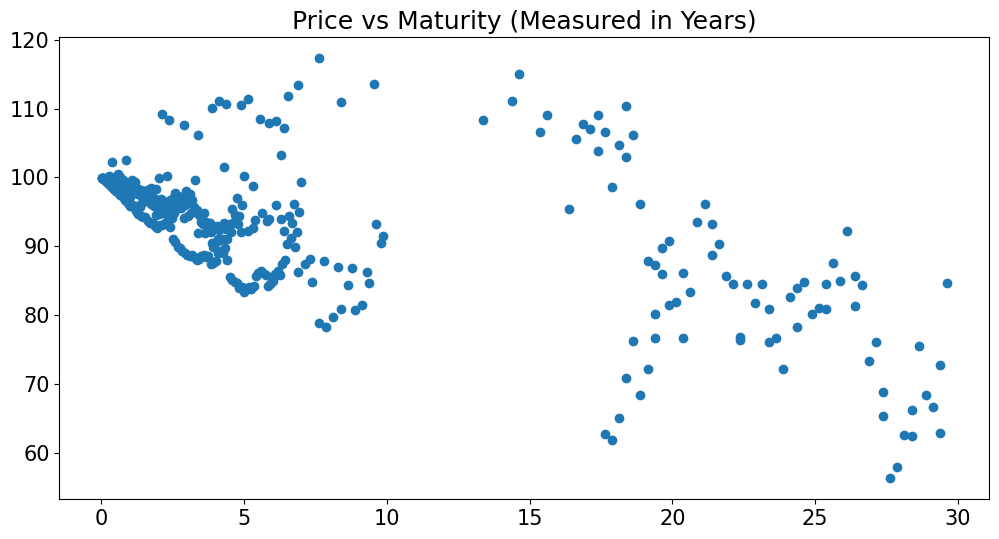

In [85]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('Price vs Maturity (Measured in Years)')
ax.scatter(treasury_metrics['Maturity'], treasury_metrics['price'])

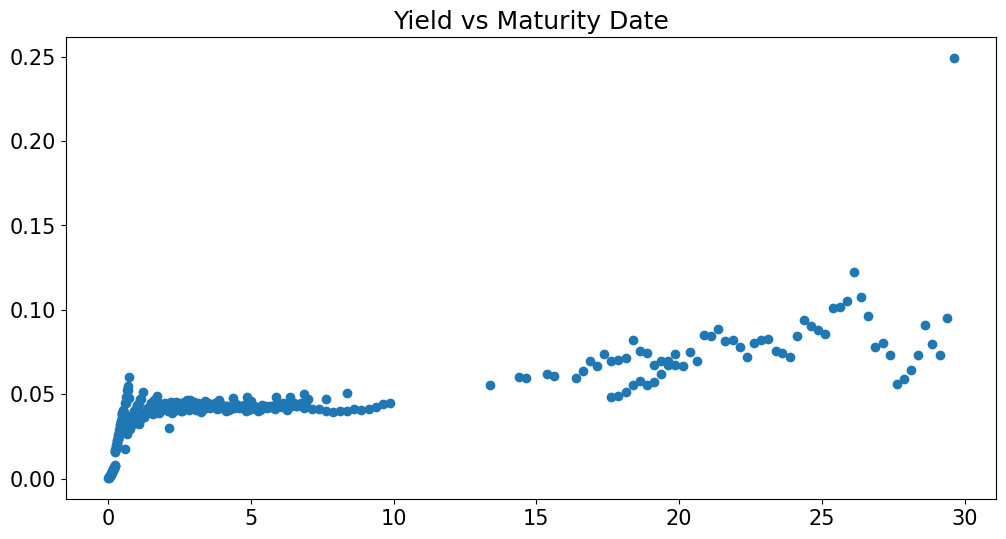

In [89]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('Yield vs Maturity Date')
ax.scatter(treasury_metrics['Maturity'], treasury_metrics['YLD'])

## Question 6| Bad Data


In [ ]:
treasury_metrics[treasury_metrics['ytm'].isna()].describe()

,Maturity,price,coupon rate,ytm,YLD,ask-bid,Periods
count,49.000000,49.000000,49.000000,0.0,49.000000,49.000000,49.000000
mean,9.584880,91.685945,0.875000,NaN,0.021024,0.107701,19.428571
std,8.895883,10.981731,0.991829,NaN,0.002885,0.083852,17.792789
min,0.292950,62.476562,0.125000,NaN,0.017118,0.007812,1.000000
25%,3.293634,87.050781,0.125000,NaN,0.019117,0.042969,7.000000
50%,5.790554,93.400391,0.500000,NaN,0.020879,0.082031,12.000000
75%,17.377139,98.388672,1.000000,NaN,0.022600,0.207031,35.000000
max,29.377139,113.630859,3.875000,NaN,0.034382,0.269531,59.000000


In [88]:
treasury_metrics = treasury_metrics.dropna()
treasury_metrics.describe()

,Maturity,price,coupon rate,ytm,YLD,ask-bid,Periods
count,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000
mean,6.255693,93.485817,1.870608,0.039594,0.044359,0.039229,12.516216
std,7.945724,9.153625,1.581789,0.004024,0.022291,0.021525,15.892969
min,0.010951,56.304688,0.000000,0.023730,0.000266,0.000111,0.000000
25%,0.968515,88.663553,0.375000,0.038496,0.039213,0.031250,2.000000
50%,2.896646,95.895225,1.750000,0.040797,0.042494,0.039062,6.000000
75%,6.478439,98.831706,2.750000,0.042371,0.045987,0.046875,13.000000
max,29.623546,117.296875,7.625000,0.043562,0.249050,0.164444,59.000000


- There are 49 rows where ytm is NaN. The average ask-bid spread is significantly higher for the dataset that includes all null values. This suggests these issues are more illiquid. Additionally, the average coupon rates are significantly lower for the NaN dataset.  


# Problem 2: Extract Discount Curve

## Question 1| 
- Create the cashflow matrix, **C**, where each row is a treasury issue, each column is a date, and each entry is the cash paid on a normalized face value of $100. 

In [93]:
Cf = calc_cashflows(df)
display(Cf)

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-30,...,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,100,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
207774,0,100,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
207893,0,0,100,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
207868,0,0,0,100,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
207430,0,0,0,0,100.6875,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207808,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.9375,0.0000,0.9375,0.0000,0.9375,0.0000,100.9375,0.0000,0.0000,0.0
207849,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.1250,0.0000,1.1250,0.0000,1.1250,0.0000,101.1250,0.0000,0.0
207850,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0625,0.0000,0.0625,0.0000,0.0625,0.0000,100.0625,0.0000,0.0


In [113]:
((Cf.sum(axis = 0)).sort_values(ascending=False)).to_frame('Date with Max Sum of Cashflow')

,Date with Max Sum of Cashflow
2023-01-31,422.0625
2023-02-15,421.5000
2023-08-15,416.2500
2025-02-15,409.0000
2025-08-15,403.4375
...,...
2030-04-15,1.6875
2030-10-15,1.6875
2031-04-15,1.6875
2029-08-28,1.5625


In [108]:
((Cf[Cf > 0].count()).sort_values(ascending= False)).to_frame('Date with most cashflow')

,Date with most cashflow
2023-02-15,87
2023-08-15,84
2024-02-15,81
2024-08-15,79
2025-02-15,77
...,...
2022-10-06,1
2027-10-31,1
2027-12-31,1
2028-02-29,1


- On February 15, 2023, there are 87 issues paying a cashflow. 
- On January 31, 2023 the most cashflow occurs on this date.